For a given ga-metadata.yaml - draw the polygon as a shapely object

In [1]:
from datetime import timedelta, datetime
import ephem
import math
import os
import sys
import time
import wget
from pyorbital.orbital import Orbital
from pyorbital import tlefile
from geographiclib.geodesic import Geodesic
import osgeo.ogr
import osgeo.osr
from osgeo import ogr
import shutil

import fiona
import folium
from IPython.display import display
import geopandas
from shapely.geometry import mapping
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import LineString
%matplotlib inline
import yaml
import pandas

In [2]:
from osgeo import gdal
gdal.__version__

'1.11.3'

In [3]:
fiona.__version__

'1.6.3'

## Get information from the RCC metadata AOS LOS and Platform

In [4]:
with open('ga-metadata.yaml', 'r') as stream:
    try:
        meta = (yaml.load(stream))
        print(meta)
    except yaml.YAMLError as exc:
        print(exc)

IOError: [Errno 2] No such file or directory: 'ga-metadata.yaml'

In [ ]:
meta['platform']['code']

In [27]:
meta['acquisition']['aos'].year

1986

In [28]:
meta['acquisition']['los']

datetime.datetime(1986, 8, 15, 23, 56, 27)

In [29]:
def dms2dec(dms):
    strdms = str(dms)
    dms = [float(x) for x in strdms.split(':')]
    dec = dms[0]+(dms[1]/60)+(dms[2]/3600)
    return dec

## From the archive TLEs find a reasonably close match to determine where the satellite was and the sub satellite position - use 7 days as the limit

In [35]:
LS5tle = 'tle/LS5_ARCHIVE.txt'
platform = meta['platform']['code']
aos = meta['acquisition']['aos']
los = meta['acquisition']['los']
deltadays = 7 # Tolerance for time delta between TLE epoch and AOS
track = []
with open(LS5tle, 'r') as f:
    data = f.readlines()
    index = 0
    found = False
    
    for line in data:
        if (line[0]=='1'):
            #print line[18:20]
            index +=1
            #print data[index]
            sat = ephem.readtle(platform,line,data[index])
            try:
                sat.compute(str(aos))
                epoch =  datetime.strptime(str(sat._epoch), "%Y/%m/%d %H:%M:%S")
                absolute = abs(aos-epoch)
                delta = timedelta(days=deltadays)
                timestep = timedelta(seconds=5)
                if absolute < delta:
                    while aos < los:
                        sat.compute(str(aos))
                        track.append([dms2dec(sat.sublong),dms2dec(sat.sublat)])
                        #print dms2dec(sat.sublat)
                        #print sat.sublat, sat.sublong
                        aos+=timestep
                    sat.compute(str(los))
                    # GO DO GETPASSES IGNORE OBSERVER
                    print track
                    satellite_track = LineString(track)
                    break
            except ValueError:
                pass            
        else:
            index +=1

    

[[143.51608333333334, -15.603666666666667], [143.44847222222222, -15.303777777777778], [143.38072222222223, -15.003916666666667], [143.31283333333334, -16.704083333333333], [143.24477777777776, -16.40425], [143.17655555555555, -16.104416666666665], [143.10819444444445, -17.80463888888889], [143.03963888888887, -17.504833333333334], [142.97094444444446, -17.20508333333333], [142.90208333333334, -18.905305555555557], [142.83302777777777, -18.605583333333335], [142.76383333333334, -18.30586111111111], [142.69441666666668, -18.006138888888888], [142.62483333333333, -19.70647222222222], [142.55505555555555, -19.406805555555557], [142.4850833333333, -19.10713888888889], [142.41491666666667, -20.8075], [142.34458333333333, -20.50788888888889], [142.274, -20.208277777777777], [142.20322222222222, -21.908694444444446], [142.13222222222223, -21.60913888888889], [142.06102777777778, -21.30961111111111], [141.9896111111111, -21.010083333333334], [141.9179722222222, -22.710583333333332], [141.84608

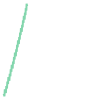

In [36]:
satellite_track

## Intersect the sub satellite track with the WRS2 map to show which path rows constitute the data segment

In [38]:
shapes = []

for pol in fiona.open('reference/wrs2_descending.shp'):
    if satellite_track.intersects(shape(pol['geometry'])):
        if shape(pol['geometry']).is_valid:
            shapes.append(shape(pol['geometry']).buffer(0))

satellite_scenes = MultiPolygon(shapes)

Self-intersection at or near point 138.71383297021046 -33.784497532375788


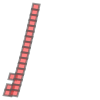

In [39]:
satellite_scenes

In [33]:
# Now convert it to a shapefile with OGR    
driver = ogr.GetDriverByName('Esri Shapefile')
ds = driver.CreateDataSource('satellite_scenes.shp')
layer = ds.CreateLayer('', None, ogr.wkbPolygon)
# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

## If there are multiple geometries, put the "for" loop here

# Create a new feature (attribute and geometry)
feat = ogr.Feature(defn)
feat.SetField('id', 123)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(satellite_scenes.wkb)
feat.SetGeometry(geom)

layer.CreateFeature(feat)
feat = geom = None  # destroy these

# Save and close everything
ds = layer = feat = geom = None

ERROR:Fiona:CPLE_AppDefined in satellite_scenes.shp is not a directory.



AttributeError: 'NoneType' object has no attribute 'CreateLayer'

## Do the same for LS7 and LS8 - the above should work for those too